# サポートベクターマシンを構築してみる（おまけ）

サポートベクターマシンは，マージンを最大化するという目的関数となりますが，線形識別器として振る舞えます．
ロジスティック回帰の目的がクラス分類間違いを尤度で表し，それを最小化するという目的に沿って動いているのとは違った原理で動いていることに注目してもらえると幸いです．

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set()
#sns.set_context('talk')

In [2]:
def gfunc2d(x, y, mu, cov):
    '''
    密度分布を求める．
    行列の要素を使うんじゃなくて，numpy らしく書けそうだけど，とりあえず．
    '''
    xz = x - mu[0]
    yz = y - mu[1]
    dlt = cov[0,0] * xz**2 + 2 * cov[0,1] * xz*yz + cov[1,1]* yz**2
    det = cov[0,0] * cov[1,1] - cov[0,1]**2
    return np.sqrt(1. / (2.*np.pi*det)) * np.exp(-0.5 * dlt)

def posterior(x, y, m1, m2, s1, s2, p1, p2):
    '''
    Class 1 の事後確率を返す
    '''
    o1 = gfunc2d(x, y, m1, s1) * p1
    o2 = gfunc2d(x, y, m2, s2) * p2
    return o1/(o1+o2)

In [3]:
# 確率と等高線描き用の座標を生成

N1 = 15 
N2 = 35
p1 = np.double(N1) / (N1 + N2)
p2 = np.double(N2) / (N1 + N2)

# メッシュグリッドを作って等高線をかけるようにする
xymin = -6
xymax = +6
Ngrid = 256
t = np.linspace(xymin, xymax, Ngrid)
xx, yy = np.meshgrid(t, t)

In [4]:
# 1つ目の例を作成，s1, s2 が広がりを制御する

# 分布の中心と共分散行列(とその逆行列)を作っておく
th1 = np.pi/3.
mu1 = np.array([[1.], [1.]]) * 1.2
mu2 = np.array([[-1.], [-1.]]) * 1.2
s1 = 2.0
s2 = 0.2
ss = np.array([[1./s1, 0.], [0, 1./s2]])
c1 = np.cos(th1)
s1 = np.sin(th1)
rot = np.array([[c1, -s1], [s1, c1]])
cv = rot.T @ ss @ rot
cvInv = np.linalg.inv(cv)

zz1 = gfunc2d(xx, yy, mu1, cv)
zz2 = gfunc2d(xx, yy, mu2, cv)

(-6.0, 6.0)

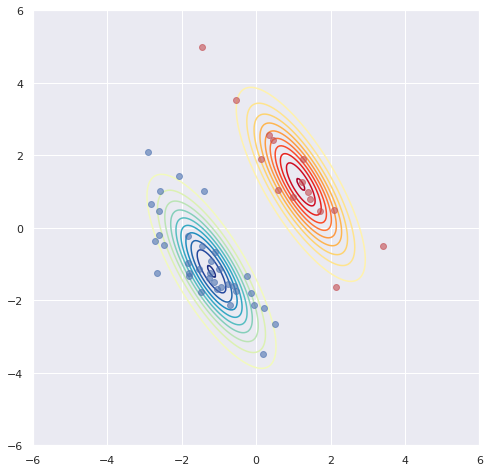

In [5]:
plt.figure(figsize=(8,8))
plt.contour(xx, yy, zz1, 10, cmap='YlOrRd')
plt.contour(xx, yy, zz2, 10, cmap='YlGnBu')

Xdat1 = np.random.multivariate_normal(mu1.flatten(), cvInv, size=N1)
plt.plot(Xdat1[:,0], Xdat1[:,1], 'ro', alpha=0.6)

Xdat2 = np.random.multivariate_normal(mu2.flatten(), cvInv, size=N2)
plt.plot( Xdat2[:,0], Xdat2[:,1], 'bo', alpha=0.6)

plt.xlim((xymin, xymax))
plt.ylim((xymin, xymax))

#plt.savefig('2class_scatter1.pdf')
#plt.savefig('2class_scatter1.svg')

SVM を導入します．といっても `sklearn.svm` から SVC (Support Vector Classifier) を導入するだけです．
あと，データの正規化を行うために前処理として `StandardScaler` （標準化処理）をするメソッドを導入します．（あるとないとで性能に違いが出てきます）
`StandardScaler` は，データの中心化（データの平均を0とするように原点を並行移動させる）ことを殺ってくれます．
`Pipeline` はこれをつないで一つの学習機械に見えるようにする仕掛けとなります．（内部では `fit` メソッドもしくは `fit_transpose` メソッドを動かすだけなので自作の前処理を入れることも可能です）

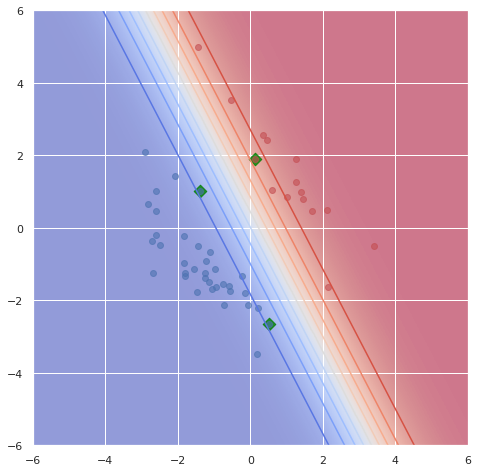

In [6]:
import sklearn
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = np.vstack((Xdat1, Xdat2))
y = np.hstack((np.ones(N1), np.zeros(N2)))

clf = Pipeline([
    ('scaler', StandardScaler()), 
    ('estimator', SVC(C=100000, kernel='linear', probability=True))]) # ハードマージンつくるの面倒なのでCをでかくとる
clf.fit(X, y)

plt.figure(figsize=(8,8))

# サンプル点の散布図
plt.plot(X[y==0, 0], X[y==0,1], 'bo', alpha=0.6)
plt.plot(X[y==1, 0], X[y==1,1], 'ro', alpha=0.6)


# 予想をマップにしてみる
pp = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))
ypred = clf.predict_proba(pp)

imshow_handle = plt.imshow( ypred[:,0].reshape(Ngrid, Ngrid), cmap='coolwarm_r',
                            extent=(xymin,xymax, xymin,xymax), origin='lower',alpha=0.5 ) # show Prob for class 0


# マップに等高線引く
plt.contour(xx, yy, ypred[:, 1].reshape(Ngrid, Ngrid), 10, cmap='coolwarm')
#plt.contour(xx, yy, ypred[:, 0].reshape(Ngrid, Ngrid), 5, cmap='YlGnBu')


# サポートベクトル表示
if(hasattr( clf['estimator'], 'support_' ) ):
    svidx = clf['estimator'].support_
    plt.scatter(X[svidx,0], X[svidx,1], color='green', marker='D', s=80, alpha=0.8)

plt.xlim((xymin, xymax))
plt.ylim((xymin, xymax))


plt.savefig('LinearSVC.png', transparent=True)

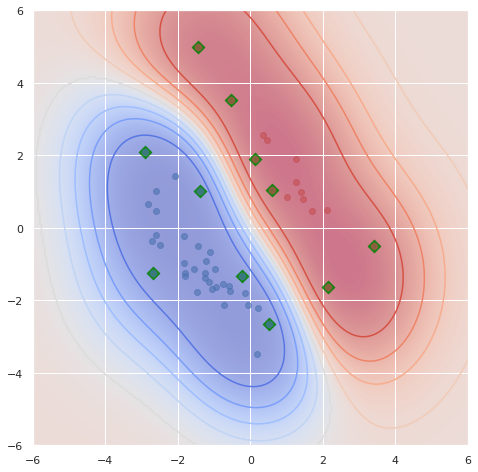

In [7]:
import sklearn
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = np.vstack((Xdat1, Xdat2))
y = np.hstack((np.ones(N1), np.zeros(N2)))

clf = Pipeline([
    ('scaler', StandardScaler()), 
    ('estimator', SVC(gamma='auto', C=100000, kernel='rbf', probability=True))])
clf.fit(X, y)

plt.figure(figsize=(8,8))

#サンプル点の散布図
plt.plot(X[y==0, 0], X[y==0,1], 'bo', alpha=0.6)
plt.plot(X[y==1, 0], X[y==1,1], 'ro', alpha=0.6)


# 予想分布の表示
pp = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))
ypred = clf.predict_proba(pp)

imshow_handle = plt.imshow( ypred[:,0].reshape(Ngrid, Ngrid), cmap='coolwarm_r',
                            extent=(xymin,xymax, xymin,xymax), origin='lower',alpha=0.5 ) # show Prob for class 0

# 予想分布の等高線
plt.contour(xx, yy, ypred[:, 1].reshape(Ngrid, Ngrid), 10, cmap='coolwarm')


#サポートベクトルの表示
if(hasattr( clf['estimator'], 'support_' ) ):
    svidx = clf['estimator'].support_
    plt.scatter(X[svidx,0], X[svidx,1], color='green', marker='D', s=80, alpha=0.8)

plt.xlim((xymin, xymax))
plt.ylim((xymin, xymax))



plt.savefig('RBFSVC.png', transparent=True)

# 線形分離不可能なケース
Soft margin SVM を採用してみる

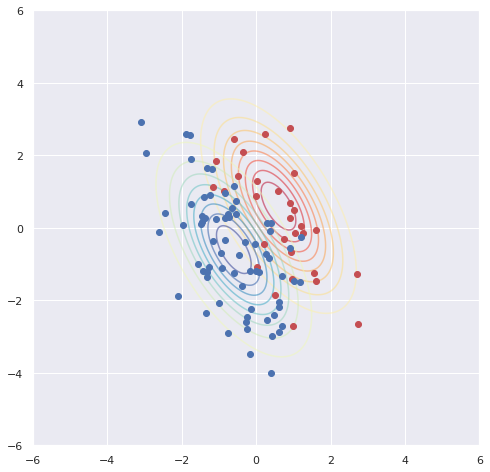

In [8]:
import sklearn
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 確率と等高線描き用の座標を生成

N1 = 15 * 2
N2 = 35 * 2
p1 = np.double(N1) / (N1 + N2)
p2 = np.double(N2) / (N1 + N2)

# メッシュグリッドを作って等高線をかけるようにする
xymin = -6
xymax = +6
Ngrid = 256
t = np.linspace(xymin, xymax, Ngrid)
xx, yy = np.meshgrid(t, t)


# 1つ目の例を作成，s1, s2 が広がりを制御する

# 分布の中心と共分散行列(とその逆行列)を作っておく
th1 = np.pi/3.
mu1 = np.array([[1.], [1.]]) * 0.6
mu2 = np.array([[-1.], [-1.]]) * 0.6
s1 = 2.5
s2 = 0.5
ss = np.array([[1./s1, 0.], [0, 1./s2]])
c1 = np.cos(th1)
s1 = np.sin(th1)
rot = np.array([[c1, -s1], [s1, c1]])
cv = rot.T @ ss @ rot
cvInv = np.linalg.inv(cv)

zz1 = gfunc2d(xx, yy, mu1, cv)
zz2 = gfunc2d(xx, yy, mu2, cv)


plt.figure(figsize=(8,8))
plt.contour(xx, yy, zz1, 10, cmap='YlOrRd', alpha=0.5)
plt.contour(xx, yy, zz2, 10, cmap='YlGnBu', alpha=0.5)

Xdat1 = np.random.multivariate_normal(mu1.flatten(), cvInv, size=N1)
plt.plot(Xdat1[:,0], Xdat1[:,1], 'ro', alpha=1.0)

Xdat2 = np.random.multivariate_normal(mu2.flatten(), cvInv, size=N2)
plt.plot( Xdat2[:,0], Xdat2[:,1], 'bo', alpha=1.0)

plt.xlim((xymin, xymax))
plt.ylim((xymin, xymax))

#plt.savefig('2class_scatter1.pdf')
#plt.savefig('2class_scatter1.svg')

# 線形分離不可能っぽいか確認
plt.savefig('LinearUnsep.png', transparent=True)

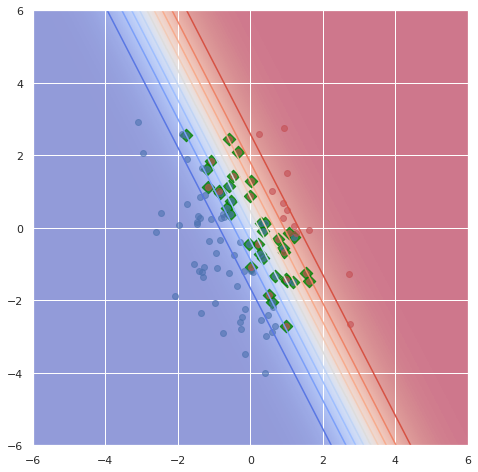

In [9]:
import sklearn
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = np.vstack((Xdat1, Xdat2))
y = np.hstack((np.ones(N1), np.zeros(N2)))

clf = Pipeline([
    ('scaler', StandardScaler()), 
    ('estimator', SVC(kernel='linear', C=1, probability=True))])
clf.fit(X, y)

plt.figure(figsize=(8,8))

#サンプル点の散布図
plt.plot(X[y==0, 0], X[y==0,1], 'bo', alpha=0.6)
plt.plot(X[y==1, 0], X[y==1,1], 'ro', alpha=0.6)


# 予想分布の表示
pp = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))
ypred = clf.predict_proba(pp)

imshow_handle = plt.imshow( ypred[:,0].reshape(Ngrid, Ngrid), cmap='coolwarm_r',
                            extent=(xymin,xymax, xymin,xymax), origin='lower',alpha=0.5 ) # show Prob for class 0

# 予想分布の等高線
plt.contour(xx, yy, ypred[:, 1].reshape(Ngrid, Ngrid), 10, cmap='coolwarm')


#サポートベクトルの表示
if(hasattr( clf['estimator'], 'support_' ) ):
    svidx = clf['estimator'].support_
    plt.scatter(X[svidx,0], X[svidx,1], color='green', marker='D', s=80, alpha=0.8)

plt.xlim((xymin, xymax))
plt.ylim((xymin, xymax))


plt.savefig('SoftLinearSVC.png', transparent=True)

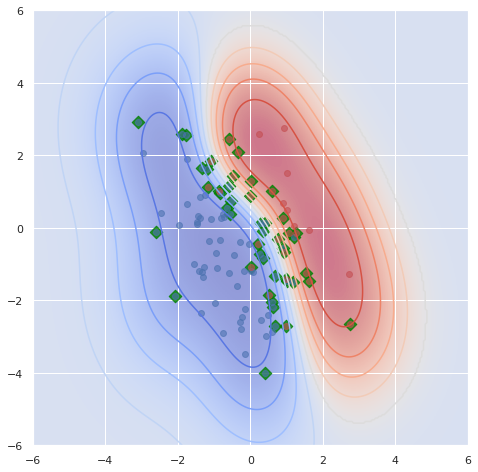

In [10]:
import sklearn
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = np.vstack((Xdat1, Xdat2))
y = np.hstack((np.ones(N1), np.zeros(N2)))

clf = Pipeline([
    ('scaler', StandardScaler()), 
    ('estimator', SVC(kernel='rbf', C=1, probability=True))])
clf.fit(X, y)

plt.figure(figsize=(8,8))

#サンプル点の散布図
plt.plot(X[y==0, 0], X[y==0,1], 'bo', alpha=0.6)
plt.plot(X[y==1, 0], X[y==1,1], 'ro', alpha=0.6)


# 予想分布の表示
pp = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))
ypred = clf.predict_proba(pp)

imshow_handle = plt.imshow( ypred[:,0].reshape(Ngrid, Ngrid), cmap='coolwarm_r',
                            extent=(xymin,xymax, xymin,xymax), origin='lower',alpha=0.5 ) # show Prob for class 0

# 予想分布の等高線
plt.contour(xx, yy, ypred[:, 1].reshape(Ngrid, Ngrid), 10, cmap='coolwarm')


#サポートベクトルの表示
if(hasattr( clf['estimator'], 'support_' ) ):
    svidx = clf['estimator'].support_
    plt.scatter(X[svidx,0], X[svidx,1], color='green', marker='D', s=80, alpha=0.8)

plt.xlim((xymin, xymax))
plt.ylim((xymin, xymax))



plt.savefig('SoftRBFSVC_1.png', transparent=True)

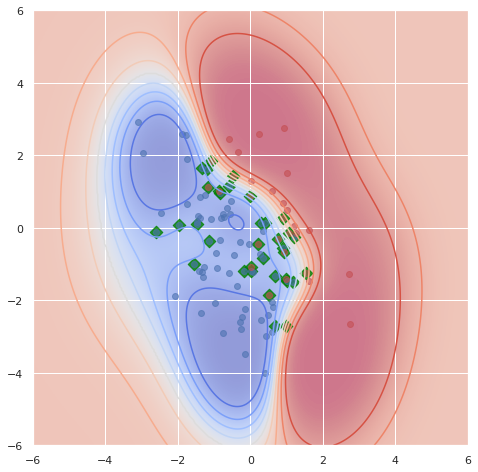

In [11]:
import sklearn
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = np.vstack((Xdat1, Xdat2))
y = np.hstack((np.ones(N1), np.zeros(N2)))

clf = Pipeline([
    ('scaler', StandardScaler()), 
    ('estimator', SVC(kernel='rbf', C=100, probability=True))])
clf.fit(X, y)

plt.figure(figsize=(8,8))

#サンプル点の散布図
plt.plot(X[y==0, 0], X[y==0,1], 'bo', alpha=0.6)
plt.plot(X[y==1, 0], X[y==1,1], 'ro', alpha=0.6)


# 予想分布の表示
pp = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))
ypred = clf.predict_proba(pp)

imshow_handle = plt.imshow( ypred[:,0].reshape(Ngrid, Ngrid), cmap='coolwarm_r',
                            extent=(xymin,xymax, xymin,xymax), origin='lower',alpha=0.5 ) # show Prob for class 0

# 予想分布の等高線
plt.contour(xx, yy, ypred[:, 1].reshape(Ngrid, Ngrid), 10, cmap='coolwarm')


#サポートベクトルの表示
if(hasattr( clf['estimator'], 'support_' ) ):
    svidx = clf['estimator'].support_
    plt.scatter(X[svidx,0], X[svidx,1], color='green', marker='D', s=80, alpha=0.8)

plt.xlim((xymin, xymax))
plt.ylim((xymin, xymax))



plt.savefig('SoftRBFSVC_100.png', transparent=True)

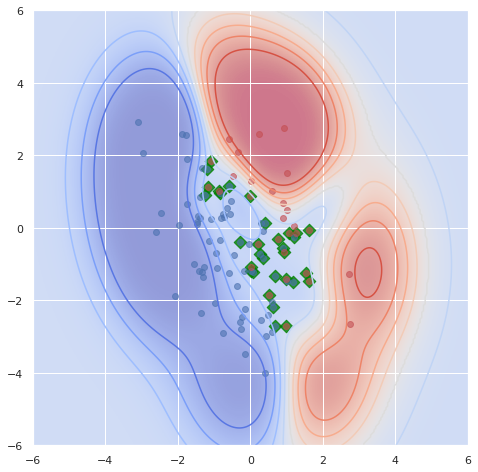

In [12]:
import sklearn
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = np.vstack((Xdat1, Xdat2))
y = np.hstack((np.ones(N1), np.zeros(N2)))

clf = Pipeline([
    ('scaler', StandardScaler()), 
    ('estimator', SVC(kernel='rbf', C=10000, probability=True))])
clf.fit(X, y)

plt.figure(figsize=(8,8))

#サンプル点の散布図
plt.plot(X[y==0, 0], X[y==0,1], 'bo', alpha=0.6)
plt.plot(X[y==1, 0], X[y==1,1], 'ro', alpha=0.6)


# 予想分布の表示
pp = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))
ypred = clf.predict_proba(pp)

imshow_handle = plt.imshow( ypred[:,0].reshape(Ngrid, Ngrid), cmap='coolwarm_r',
                            extent=(xymin,xymax, xymin,xymax), origin='lower',alpha=0.5 ) # show Prob for class 0

# 予想分布の等高線
plt.contour(xx, yy, ypred[:, 1].reshape(Ngrid, Ngrid), 10, cmap='coolwarm')


#サポートベクトルの表示
if(hasattr( clf['estimator'], 'support_' ) ):
    svidx = clf['estimator'].support_
    plt.scatter(X[svidx,0], X[svidx,1], color='green', marker='D', s=80, alpha=0.8)

plt.xlim((xymin, xymax))
plt.ylim((xymin, xymax))



plt.savefig('SoftRBFSVC_10000.png', transparent=True)

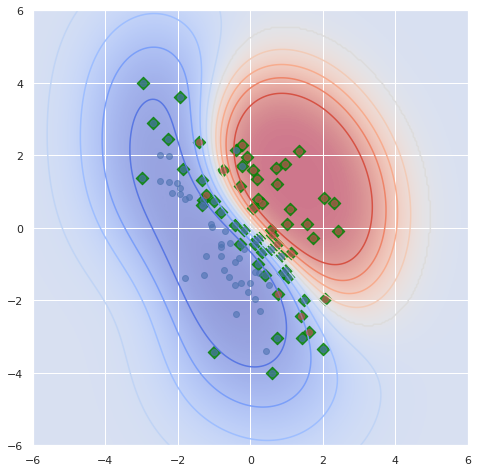

In [42]:
import sklearn
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = np.vstack((Xdat1, Xdat2))
y = np.hstack((np.ones(N1), np.zeros(N2)))

clf = Pipeline([
    ('scaler', StandardScaler()), 
    ('estimator', SVC(kernel='rbf', C=0.01, probability=True))])
clf.fit(X, y)

plt.figure(figsize=(8,8))

#サンプル点の散布図
plt.plot(X[y==0, 0], X[y==0,1], 'bo', alpha=0.6)
plt.plot(X[y==1, 0], X[y==1,1], 'ro', alpha=0.6)


# 予想分布の表示
pp = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))
ypred = clf.predict_proba(pp)

imshow_handle = plt.imshow( ypred[:,0].reshape(Ngrid, Ngrid), cmap='coolwarm_r',
                            extent=(xymin,xymax, xymin,xymax), origin='lower',alpha=0.5 ) # show Prob for class 0

# 予想分布の等高線
plt.contour(xx, yy, ypred[:, 1].reshape(Ngrid, Ngrid), 10, cmap='coolwarm')


#サポートベクトルの表示
if(hasattr( clf['estimator'], 'support_' ) ):
    svidx = clf['estimator'].support_
    plt.scatter(X[svidx,0], X[svidx,1], color='green', marker='D', s=80, alpha=0.8)

plt.xlim((xymin, xymax))
plt.ylim((xymin, xymax))



plt.savefig('SoftRBFSVC_001.png', transparent=True)